In [170]:
from src.distance_measures import analyse_image
from src.gaussian_noise import generate_noise
from src.preprocessing import process_image
import matplotlib.pyplot as plt
import torch

In [171]:
size = 300
thresh = torch.tensor(0.3, requires_grad=True, dtype=torch.float64)
disk = torch.tensor(4, requires_grad=True, dtype=torch.float64)

In [172]:
def model(x):
    noise = generate_noise(size=size, threshold=thresh.item(), disk_size=disk.item())
    F, G = analyse_image(noise[0], L=50)
    return torch.tensor(F/G)

In [173]:
im = process_image('images/1carr-96etoh-alexa-sted-decon.tif', threshold=thresh.item(), size=size)
F, G = analyse_image(im, L=50)

In [174]:
x = torch.arange(len(F), dtype=torch.float64)
y = torch.tensor(F/G)

In [175]:
learning_rate = 0.01
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD([thresh, disk], lr=learning_rate)

In [176]:
num_epochs = 100
loss_BGD = []

for epoch in range(num_epochs):
    # Forward pass
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    
    loss_BGD.append(loss.item())
    # loss = Variable(loss, requires_grad = True)

    # Backward pass and optimization
    # optimizer.zero_grad()
    # thresh.retain_grad()
    # disk.retain_grad()
    loss.requires_grad = True
    loss.backward()
    optimizer.step()

    # loss.backward()
    # thresh.data = thresh.data - learning_rate * thresh.grad.data
    # disk.data = disk.data - learning_rate * disk.grad.data
    # thresh.grad.data.zero_()
    # disk.grad.data.zero_()
    
    # Print the loss at every 10th epoch
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 0.0195


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    y_pred = model(x)
    print(f"Predicted y:\n{y_pred}")

Predicted y:
tensor([0.0000, 0.0000, 0.0108, 0.0277, 0.0346, 0.0374, 0.0395, 0.0392, 0.0386,
        0.0397, 0.0411, 0.0424, 0.0437, 0.0447, 0.0456, 0.0467, 0.0475, 0.0485,
        0.0492, 0.0496, 0.0498, 0.0498, 0.0496, 0.0494, 0.0492, 0.0492, 0.0491,
        0.0490, 0.0490, 0.0490, 0.0490, 0.0491, 0.0491, 0.0491, 0.0490, 0.0489,
        0.0489, 0.0489, 0.0489, 0.0489, 0.0489, 0.0489, 0.0490, 0.0490, 0.0490,
        0.0491, 0.0491, 0.0491, 0.0490, 0.0489, 0.0489], dtype=torch.float64)


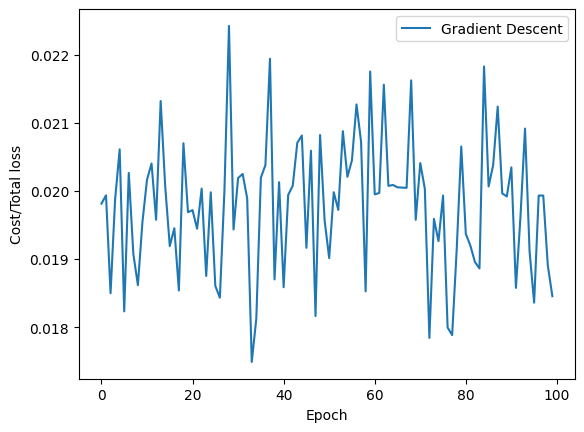

In [ ]:
plt.plot(loss_BGD, label="Gradient Descent")
plt.xlabel('Epoch')
plt.ylabel('Cost/Total loss')
plt.legend()
plt.show()

In [ ]:
thresh.item()
disk.item()

4.0

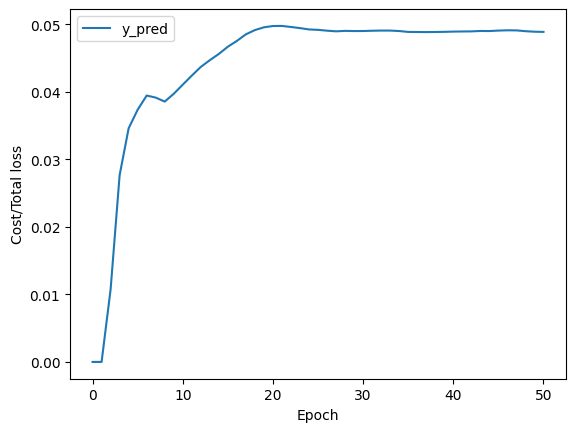

In [ ]:
plt.plot(y_pred, label="y_pred")
plt.xlabel('Epoch')
plt.ylabel('Cost/Total loss')
plt.legend()
plt.show()